In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import itertools
import logging
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as utils
import math
import time
import tqdm

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal

import torch.nn as nn
import torch.nn.init as init
import sys

sys.path.append("../new_flows")
from flows import RealNVP, Planar, MAF
from models import NormalizingFlowModel
import random
from torch.autograd import Variable

In [2]:
import random
from torch.autograd import Variable

In [3]:
df_purebkg = pd.read_hdf("/data/t3home000/spark/LHCOlympics_previous/preprocessed_40part_testdataset.h5")

In [4]:
dt = df_purebkg.values

In [5]:
dt.shape

(1100000, 121)

In [6]:
idx = dt[:,120]
bkg_idx = np.where(idx==0)[0]
sig_idx = np.where(idx==1)[0]

In [7]:
dt = dt[:,:120]
label = idx

In [8]:
dt.shape

(1100000, 120)

In [9]:
label.shape

(1100000,)

In [10]:
data = np.reshape(dt, (-1,40,3))

In [11]:
data.shape

(1100000, 40, 3)

In [12]:
label

array([0., 0., 0., ..., 0., 0., 0.])

In [13]:
#data_bkg = dt[bkg_idx]

#data_sig = dt[sig_idx]

#data_bkg = data_bkg[:,0:120]

#data_sig = data_sig[:,0:120]

#data_bkg = np.reshape(data_bkg, (-1,40,3))

#data_bkg.shape # (Nevents, Npfcands, Nfeats)

#data_sig = np.reshape(data_sig, (-1,40,3))

#data_sig.shape

# 40 Body System, 3 features ( pT, eta, Phi) for each object (PF candidate)

In [14]:
n_objects  = 40 # number of PF candidates(nodes)
object_dim = 3 # features: mass, x coordinate, y coordinate, speed on x-axis, speed on y-axis

n_relations  = n_objects * (n_objects - 1) # number of edges in fully connected graph
relation_dim = 1

effect_dim = 10 #effect's vector size


In [15]:
n_relations

1560

In [16]:
data.shape

(1100000, 40, 3)

In [17]:
def get_batch(data, label, idx, batch_size):
    
    start_idx = idx*batch_size
    end_idx = idx*batch_size+batch_size

    batch_data = data[start_idx: end_idx]
    label_data = label[start_idx: end_idx]
    
    objects = batch_data
    
    
    #receiver_relations, sender_relations - onehot encoding matrices
    #each column indicates the receiver and sender object’s index
    
    receiver_relations = np.zeros((batch_size, n_objects, n_relations), dtype=float);
    sender_relations   = np.zeros((batch_size, n_objects, n_relations), dtype=float);
    
    cnt = 0
    for i in range(n_objects):
        for j in range(n_objects):
            if(i != j):
                receiver_relations[:, i, cnt] = 1.0
                sender_relations[:, j, cnt]   = 1.0
                cnt += 1
    
    #There is no relation info in solar system task, just fill with zeros
    relation_info = np.zeros((batch_size, n_relations, relation_dim))
    target = label_data
    
    objects            = Variable(torch.FloatTensor(objects))
    sender_relations   = Variable(torch.FloatTensor(sender_relations))
    receiver_relations = Variable(torch.FloatTensor(receiver_relations))
    relation_info      = Variable(torch.FloatTensor(relation_info))
    target             = Variable(torch.FloatTensor(target))
                       
    if USE_CUDA:
        objects            = objects.cuda()
        sender_relations   = sender_relations.cuda()
        receiver_relations = receiver_relations.cuda()
        relation_info      = relation_info.cuda()
        target             = target.cuda()
    
    return objects, sender_relations, receiver_relations, relation_info, target


In [18]:
class RelationalModel(nn.Module):
    def __init__(self, input_size, output_size, hidden_size):
        super(RelationalModel, self).__init__()
        
        self.output_size = output_size
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.ReLU()
        )
    
    def forward(self, x):
        '''
        Args:
            x: [batch_size, n_relations, input_size]
        Returns:
            [batch_size, n_relations, output_size]
        '''
        batch_size, n_relations, input_size = x.size()
        x = x.view(-1, input_size)
        x = self.layers(x)
        x = x.view(batch_size, n_relations, self.output_size)
        return x

In [19]:
class ObjectModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(ObjectModel, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1), #speedX and speedY
        )
        
    def forward(self, x):
        '''
        Args:
            x: [batch_size, n_objects, input_size]
        Returns:
            [batch_size * n_objects, 2] speedX and speedY
        '''
        input_size = x.size(2)*x.size(1)
        x = x.view(-1, input_size)
        return self.layers(x)


In [20]:
class InteractionNetwork(nn.Module):
    def __init__(self, n_objects, object_dim, n_relations, relation_dim, effect_dim):
        super(InteractionNetwork, self).__init__()
        
        self.relational_model = RelationalModel(2*object_dim + relation_dim, effect_dim, 150)
        self.object_model     = ObjectModel((object_dim + effect_dim)*n_objects, 100)
    
    def forward(self, objects, sender_relations, receiver_relations, relation_info):
        senders   = sender_relations.permute(0, 2, 1).bmm(objects)
        receivers = receiver_relations.permute(0, 2, 1).bmm(objects)
        effects = self.relational_model(torch.cat([senders, receivers, relation_info], 2))
        effect_receivers = receiver_relations.bmm(effects)
        predicted = self.object_model(torch.cat([objects, effect_receivers], 2))
        return predicted

In [21]:
USE_CUDA = True

In [22]:
interaction_network = InteractionNetwork(n_objects, object_dim, n_relations, relation_dim, effect_dim)

if USE_CUDA:
    interaction_network = interaction_network.cuda()
    
optimizer = optim.Adam(interaction_network.parameters())
criterion = nn.BCEWithLogitsLoss()



In [25]:
from IPython.display import clear_output

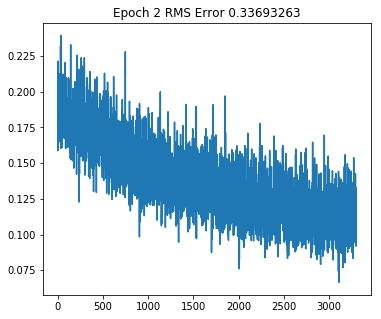

0.0 percent
0.09090909090909091 percent
0.18181818181818182 percent
0.27272727272727276 percent
0.36363636363636365 percent
0.45454545454545453 percent
0.5454545454545455 percent
0.6363636363636364 percent
0.7272727272727273 percent
0.8181818181818182 percent
0.9090909090909091 percent
1.0 percent
1.090909090909091 percent
1.1818181818181819 percent
1.2727272727272727 percent
1.3636363636363635 percent
1.4545454545454546 percent
1.5454545454545454 percent
1.6363636363636365 percent
1.7272727272727273 percent
1.8181818181818181 percent
1.9090909090909092 percent
2.0 percent
2.090909090909091 percent
2.181818181818182 percent
2.272727272727273 percent
2.3636363636363638 percent
2.4545454545454546 percent
2.5454545454545454 percent
2.6363636363636362 percent
2.727272727272727 percent
2.8181818181818183 percent
2.909090909090909 percent
3.0 percent
3.090909090909091 percent
3.1818181818181817 percent
3.272727272727273 percent
3.3636363636363638 percent
3.4545454545454546 percent
3.54545454

29.272727272727273 percent
29.363636363636363 percent
29.454545454545457 percent
29.545454545454547 percent
29.63636363636364 percent
29.72727272727273 percent
29.818181818181817 percent
29.909090909090907 percent
30.0 percent
30.09090909090909 percent
30.181818181818183 percent
30.272727272727273 percent
30.363636363636363 percent
30.454545454545457 percent
30.545454545454547 percent
30.636363636363633 percent
30.727272727272727 percent
30.818181818181817 percent
30.909090909090907 percent
31.0 percent
31.09090909090909 percent
31.181818181818183 percent
31.272727272727273 percent
31.363636363636367 percent
31.454545454545457 percent
31.545454545454543 percent
31.636363636363633 percent
31.727272727272727 percent
31.818181818181817 percent
31.90909090909091 percent
32.0 percent
32.09090909090909 percent
32.18181818181819 percent
32.27272727272727 percent
32.36363636363636 percent
32.45454545454545 percent
32.54545454545455 percent
32.63636363636363 percent
32.72727272727273 percent
32

KeyboardInterrupt: 

In [26]:
n_epoch = 100
batch_size=1000
batches_per_epoch = int(len(data)/batch_size)

losses = []
for epoch in range(n_epoch):
    for idx in range(batches_per_epoch):
        print((idx/batches_per_epoch)*100,"percent")
        objects, sender_relations, receiver_relations, relation_info, target = get_batch(data, label, idx, batch_size)
        predicted = interaction_network(objects, sender_relations, receiver_relations, relation_info)
        loss = criterion(predicted.flatten(), target)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        losses.append(loss.data.cpu().numpy())
        
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('Epoch %s RMS Error %s' % (epoch, np.sqrt(np.mean(losses[-100:]))))
    plt.plot(losses)
    plt.show()

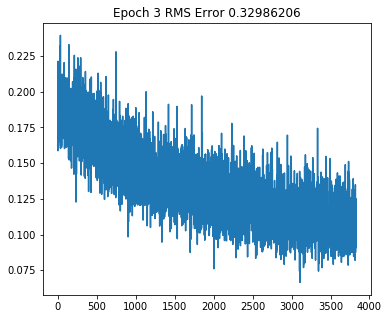

In [27]:
plt.figure(figsize=(20,5))
plt.subplot(131)
plt.title('Epoch %s RMS Error %s' % (epoch, np.sqrt(np.mean(losses[-100:]))))
plt.plot(losses)
plt.show()

In [28]:
data_bkg = dt[bkg_idx]

data_sig = dt[sig_idx]

In [30]:
data_bkg.shape

(1000000, 120)

In [32]:
label_bkg = label[bkg_idx]

In [33]:
label_sig = label[sig_idx]

In [37]:
dfsd = []
tester = [12,3]

In [41]:
test1 = np.array([1,2])

In [42]:
test2 = np.array([3,4])

In [43]:
test1

array([1, 2])

In [44]:
np.concatenate(test1, test2)

TypeError: only integer scalar arrays can be converted to a scalar index

In [45]:
interaction_network.eval()

InteractionNetwork(
  (relational_model): RelationalModel(
    (layers): Sequential(
      (0): Linear(in_features=7, out_features=150, bias=True)
      (1): ReLU()
      (2): Linear(in_features=150, out_features=150, bias=True)
      (3): ReLU()
      (4): Linear(in_features=150, out_features=10, bias=True)
      (5): ReLU()
    )
  )
  (object_model): ObjectModel(
    (layers): Sequential(
      (0): Linear(in_features=520, out_features=100, bias=True)
      (1): ReLU()
      (2): Linear(in_features=100, out_features=100, bias=True)
      (3): ReLU()
      (4): Linear(in_features=100, out_features=1, bias=True)
    )
  )
)

In [51]:
data_bkg = np.reshape(data_bkg, (-1,40,3))

In [52]:
data_bkg.shape

(1000000, 40, 3)

In [53]:
batch_size=1000
batches_per_epoch = int(len(data_bkg)/batch_size)

bkg_losses = np.array([])

for idx in range(batches_per_epoch):
    print((idx/batches_per_epoch)*100,"percent")
    objects, sender_relations, receiver_relations, relation_info, target = get_batch(data_bkg, label_bkg, idx, batch_size)

    
    predicted = interaction_network(objects, sender_relations, receiver_relations, relation_info)

    bkg_losses = np.concatenate((bkg_losses,predicted.flatten().data.cpu().numpy()))
        


0.0 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
0.1 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
0.2 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
0.3 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
0.4 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
0.5 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
0.6 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
0.7000000000000001 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 156

torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
6.5 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
6.6000000000000005 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
6.7 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
6.800000000000001 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
6.9 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
7.000000000000001 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
7.1 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch

torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
13.0 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
13.100000000000001 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
13.200000000000001 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
13.3 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
13.4 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
13.5 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
13.600000000000001 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])

torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
19.400000000000002 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
19.5 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
19.6 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
19.7 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
19.8 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
19.900000000000002 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
20.0 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1

torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
25.900000000000002 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
26.0 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
26.1 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
26.200000000000003 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
26.3 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
26.400000000000002 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
26.5 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])

torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
32.2 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
32.300000000000004 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
32.4 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
32.5 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
32.6 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
32.7 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
32.800000000000004 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1

torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
38.7 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
38.800000000000004 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
38.9 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
39.0 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
39.1 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
39.2 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
39.300000000000004 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1

torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
45.2 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
45.300000000000004 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
45.4 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
45.5 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
45.6 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
45.7 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
45.800000000000004 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1

torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
51.7 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
51.800000000000004 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
51.9 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
52.0 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
52.1 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
52.2 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
52.300000000000004 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1

torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
57.9 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
57.99999999999999 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
58.099999999999994 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
58.199999999999996 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
58.3 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
58.4 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
58.5 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])


torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
64.3 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
64.4 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
64.5 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
64.60000000000001 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
64.7 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
64.8 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
64.9 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])


torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
70.7 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
70.8 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
70.89999999999999 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
71.0 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
71.1 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
71.2 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
71.3 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])


torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
77.2 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
77.3 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
77.4 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
77.5 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
77.60000000000001 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
77.7 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
77.8 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])


torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
83.6 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
83.7 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
83.8 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
83.89999999999999 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
84.0 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
84.1 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
84.2 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])


torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
90.2 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
90.3 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
90.4 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
90.5 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
90.60000000000001 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
90.7 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
90.8 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])


torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
96.6 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
96.7 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
96.8 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
96.89999999999999 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
97.0 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
97.1 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])
97.2 percent
torch.Size([1000, 40, 3])
torch.Size([1000, 40, 1560])
torch.Size([1000, 40, 1560])
torch.Size([1000, 1560, 1])


In [54]:
bkg_losses

array([ -8.60704994,  -4.13210917, -10.95484447, ...,  -5.51887989,
        -7.93360186,  -7.51877642])

(array([4.00000e+00, 2.00000e+00, 1.20000e+01, 4.80000e+01, 5.27000e+02,
        1.00940e+04, 1.76069e+05, 6.18013e+05, 1.89978e+05, 5.25300e+03]),
 array([-38.84955978, -34.45838013, -30.06720047, -25.67602081,
        -21.28484116, -16.8936615 , -12.50248184,  -8.11130219,
         -3.72012253,   0.67105713,   5.06223679]),
 <a list of 10 Patch objects>)

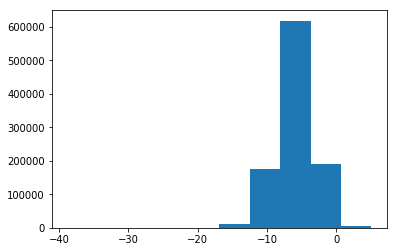

In [55]:
plt.hist(bkg_losses)

In [56]:
data_sig = np.reshape(data_sig, (-1,40,3))

In [57]:
data_sig.shape

(100000, 40, 3)

In [58]:
batch_size=1000
batches_per_epoch = int(len(data_sig)/batch_size)

sig_losses = np.array([])

for idx in range(batches_per_epoch):
    print((idx/batches_per_epoch)*100,"percent")
    objects, sender_relations, receiver_relations, relation_info, target = get_batch(data_sig, label_sig, idx, batch_size)

    
    predicted = interaction_network(objects, sender_relations, receiver_relations, relation_info)

    sig_losses = np.concatenate((sig_losses,predicted.flatten().data.cpu().numpy()))
        


0.0 percent
1.0 percent
2.0 percent
3.0 percent
4.0 percent
5.0 percent
6.0 percent
7.000000000000001 percent
8.0 percent
9.0 percent
10.0 percent
11.0 percent
12.0 percent
13.0 percent
14.000000000000002 percent
15.0 percent
16.0 percent
17.0 percent
18.0 percent
19.0 percent
20.0 percent
21.0 percent
22.0 percent
23.0 percent
24.0 percent
25.0 percent
26.0 percent
27.0 percent
28.000000000000004 percent
28.999999999999996 percent
30.0 percent
31.0 percent
32.0 percent
33.0 percent
34.0 percent
35.0 percent
36.0 percent
37.0 percent
38.0 percent
39.0 percent
40.0 percent
41.0 percent
42.0 percent
43.0 percent
44.0 percent
45.0 percent
46.0 percent
47.0 percent
48.0 percent
49.0 percent
50.0 percent
51.0 percent
52.0 percent
53.0 percent
54.0 percent
55.00000000000001 percent
56.00000000000001 percent
56.99999999999999 percent
57.99999999999999 percent
59.0 percent
60.0 percent
61.0 percent
62.0 percent
63.0 percent
64.0 percent
65.0 percent
66.0 percent
67.0 percent
68.0 percent
69.0 

In [59]:
sig_losses

array([-1.75505102,  1.56903899,  1.27821565, ...,  0.36353493,
       -0.02839164,  0.76360005])

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 2.0000e-05, 1.0000e-05, 9.0000e-05,
        1.0000e-04, 3.6000e-04, 1.2500e-03, 3.0300e-03, 7.5900e-03,
        1.6470e-02, 3.0540e-02, 5.4160e-02, 8.3890e-02, 1.2542e-01,
        1.5815e-01, 1.7086e-01, 1.5940e-01, 1.1507e-01, 5.5270e-02,
        1.6130e-02, 2.1000e-03, 9.0000e-05, 0.0000e+00]),
 array([-20, -19, -18, -17, -16, -15, -14, -13, -12, -11, -10,  -9,  -8,
         -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,   4,   5,
          6,   7,   8,   9]),
 <a list of 29 Patch objects>)

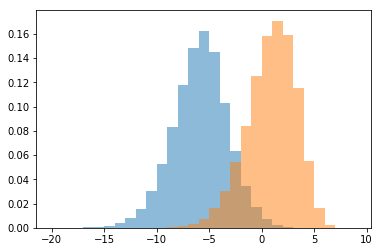

In [64]:
plt.hist(bkg_losses,bins=np.arange(-20,10,1),density=True,alpha=0.5)
plt.hist(sig_losses,bins=np.arange(-20,10,1),density=True,alpha=0.5)

In [68]:
len(np.where(sig_losses>1)[0])

51892

In [69]:
len(sig_losses)

100000

In [72]:
def make_roc(bkg_losses,sig_losses):
    bins = np.arange(-20,10,0.5)
    for bin_edge in bins:
        tpr.append(len(np.where(sig_losses>bin_edge)[0])/len(sig_losses))
        fpr.append(len(np.where(bkg_losses>bin_edge)[0])/len(bkg_losses))
        

In [73]:
tpr = []
fpr = []
make_roc(bkg_losses,sig_losses)
        
        

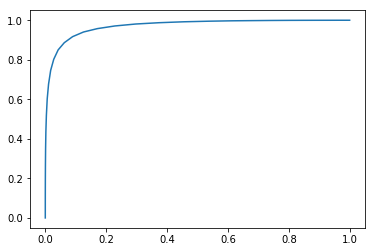

In [75]:
plt.plot(fpr,tpr)